In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [3]:
from fastai.vision import *
from fastai.metrics import error_rate

In [4]:
dict_helper = {'black':'urls_black.txt',
               'teddys':'urls_teddys.txt',
               'grizzly':'urls_grizzly.txt'}


In [6]:
for folder,file in dict_helper.items():
  path = Path('data/bears')
  dest = path/folder
  dest.mkdir(parents=True, exist_ok=True)
  download_images(path/file, dest, max_pics=200)

In [7]:
classes = ['teddys','grizzly','black']

In [8]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

teddys


grizzly


black


In [9]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path,train='.',valid_pct=0.2,ds_tfms=get_transforms(),size=224)
data = data.normalize(imagenet_stats)

In [11]:
data.classes

['black', 'grizzly', 'teddys']

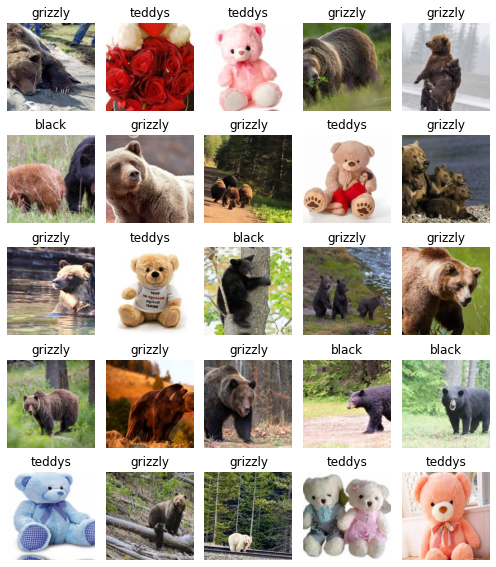

In [12]:
data.show_batch(rows=5,figsize=(7,8))

In [13]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['black', 'grizzly', 'teddys'], 3, 109, 27)

In [14]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [15]:
learn.fit_one_cycle(4)

In [16]:
learn.save('stage-1')

In [17]:
learn.unfreeze()

In [18]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


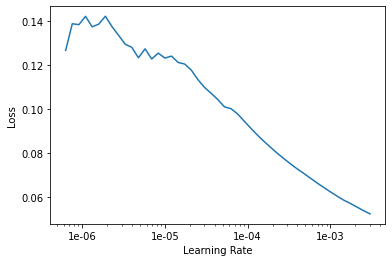

In [19]:
learn.recorder.plot()

In [20]:
learn.fit_one_cycle(2, max_lr=slice(5e-5,3e-4))

In [21]:
learn.save('stage-2')

In [22]:
learn.load('stage-2');

In [23]:
interp = ClassificationInterpretation.from_learner(learn)

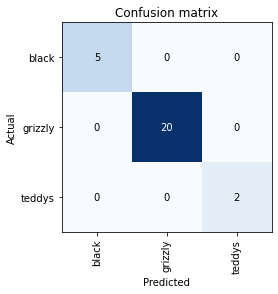

In [24]:
interp.plot_confusion_matrix()

In [25]:
from fastai.widgets import *

In [26]:
db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

In [27]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)

learn_cln.load('stage-2');

In [28]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

In [29]:
ds, idxs = DatasetFormatter().from_similars(learn_cln)

Getting activations...


Computing similarities...


In [30]:
learn.export()

In [31]:
defaults.device = torch.device('cpu')

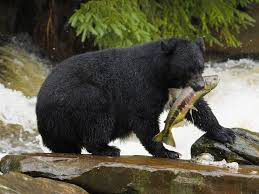

In [32]:
img = open_image(path/'black'/'00000021.jpg')
img

In [33]:
learn = load_learner(path)

In [34]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class.obj

'black'

In [36]:
"""@app.route("/classify-url", methods=["GET"])
async def classify_url(request):
    bytes = await get_bytes(request.query_params["url"])
    img = open_image(BytesIO(bytes))
    _,_,losses = learner.predict(img)
    return JSONResponse({
        "predictions": sorted(
            zip(cat_learner.data.classes, map(float, losses)),
            key=lambda p: p[1],
            reverse=True
        )
    })"""

'@app.route("/classify-url", methods=["GET"])\nasync def classify_url(request):\n    bytes = await get_bytes(request.query_params["url"])\n    img = open_image(BytesIO(bytes))\n    _,_,losses = learner.predict(img)\n    return JSONResponse({\n        "predictions": sorted(\n            zip(cat_learner.data.classes, map(float, losses)),\n            key=lambda p: p[1],\n            reverse=True\n        )\n    })'